In [1]:
import os, sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

from models_mask10_class1 import VGG as model_cifar
import pandas as pd
import argparse
import csv
from torch.optim.lr_scheduler import MultiStepLR
from dataLoader import DataLoader

from sklearn.metrics import confusion_matrix, classification_report    # 生成混淆矩阵函数
import matplotlib.pyplot as plt    # 绘图库
from PIL import Image, ImageDraw

print('Init Finished!')

Init Finished!


# Model Load

In [2]:
args_depth = 20
num_classes = 10
args_dataset = 'cifar-10'
args_batch_size = 512
PATH = '/data/ouyangzhihao/Exp/ICNN/Resnet_ICNN/tb_dir/cifar_exp/test_256bs_150epoch_layer3_Vgg_baseline'
# PATH = '/data/ouyangzhihao/Exp/ICNN/Resnet_ICNN/tb_dir/cifar_exp/test_256bs_150epoch_layer3_Vgg_mask1'
model_path = os.path.join(PATH, 'saved_model.pt')


In [3]:
# Data Loader
loader = DataLoader(args_dataset,batch_size=args_batch_size)
dataloaders,dataset_sizes = loader.load_data()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
model = model_cifar("VGG16")
model = model.cuda()
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_path))
print('Successfully Load Model: ', os.path.basename(model_path))

Successfully Load Model:  saved_model.pt


In [5]:
def printF(i, total=100):
    i = int( i / total * 100) + 1
    total = 100
    k = i + 1
    str_ = '>'*i + '' ''*(total-k)
    sys.stdout.write('\r'+str_+'[%s%%]'%(i+1))
    sys.stdout.flush()
    if(i >= total -1): print()

In [6]:
use_gpu = True
epoch = 1
phase = 'val'
running_corrects = 0.0
data_len = len(dataloaders[phase])
# print(data_len)
true_labels = []
model_preds = []
for idx,data in enumerate(dataloaders[phase]):
    printF(idx, data_len)
    inputs,labels = data
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    #forward
    outputs = model(inputs, labels, epoch)
    _, preds = torch.max(outputs.data, 1)
    # _,top5_preds = torch.topk(outputs.data,k=5,dim=1)
    # print ('group loss:',group_loss[0])
    y = labels.data
    batch_size = labels.data.shape[0]
    # print(y.resize_(batch_size,1))
    running_corrects += torch.sum(preds == y)
    # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
    epoch_acc = float(running_corrects) /dataset_sizes[phase]
    true_labels.extend(y.cpu().numpy())
    model_preds.extend(preds.cpu().numpy())
print('%s top1 Acc:%.4f'%(phase,epoch_acc))


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.9007


In [7]:
labels_name = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')
def plot_confusion_matrix_and_text(cm, labels_name, title):
    plt.figure(figsize=(16,16),dpi=200)
    plt.subplot(221)
    plot_confusion_matrix(cm, labels_name, title)
    plt.subplot(222)
    
    text_img = Image.new('RGB', (350, 250), color = (255,255,255))
    d = ImageDraw.Draw(text_img)
    text_content = classification_report(true_labels, model_preds, target_names=labels_name)
    d.text((0,0), text_content, fill=(0,0,0))
    plt.imshow(text_img)
    plt.show()

# Baseline

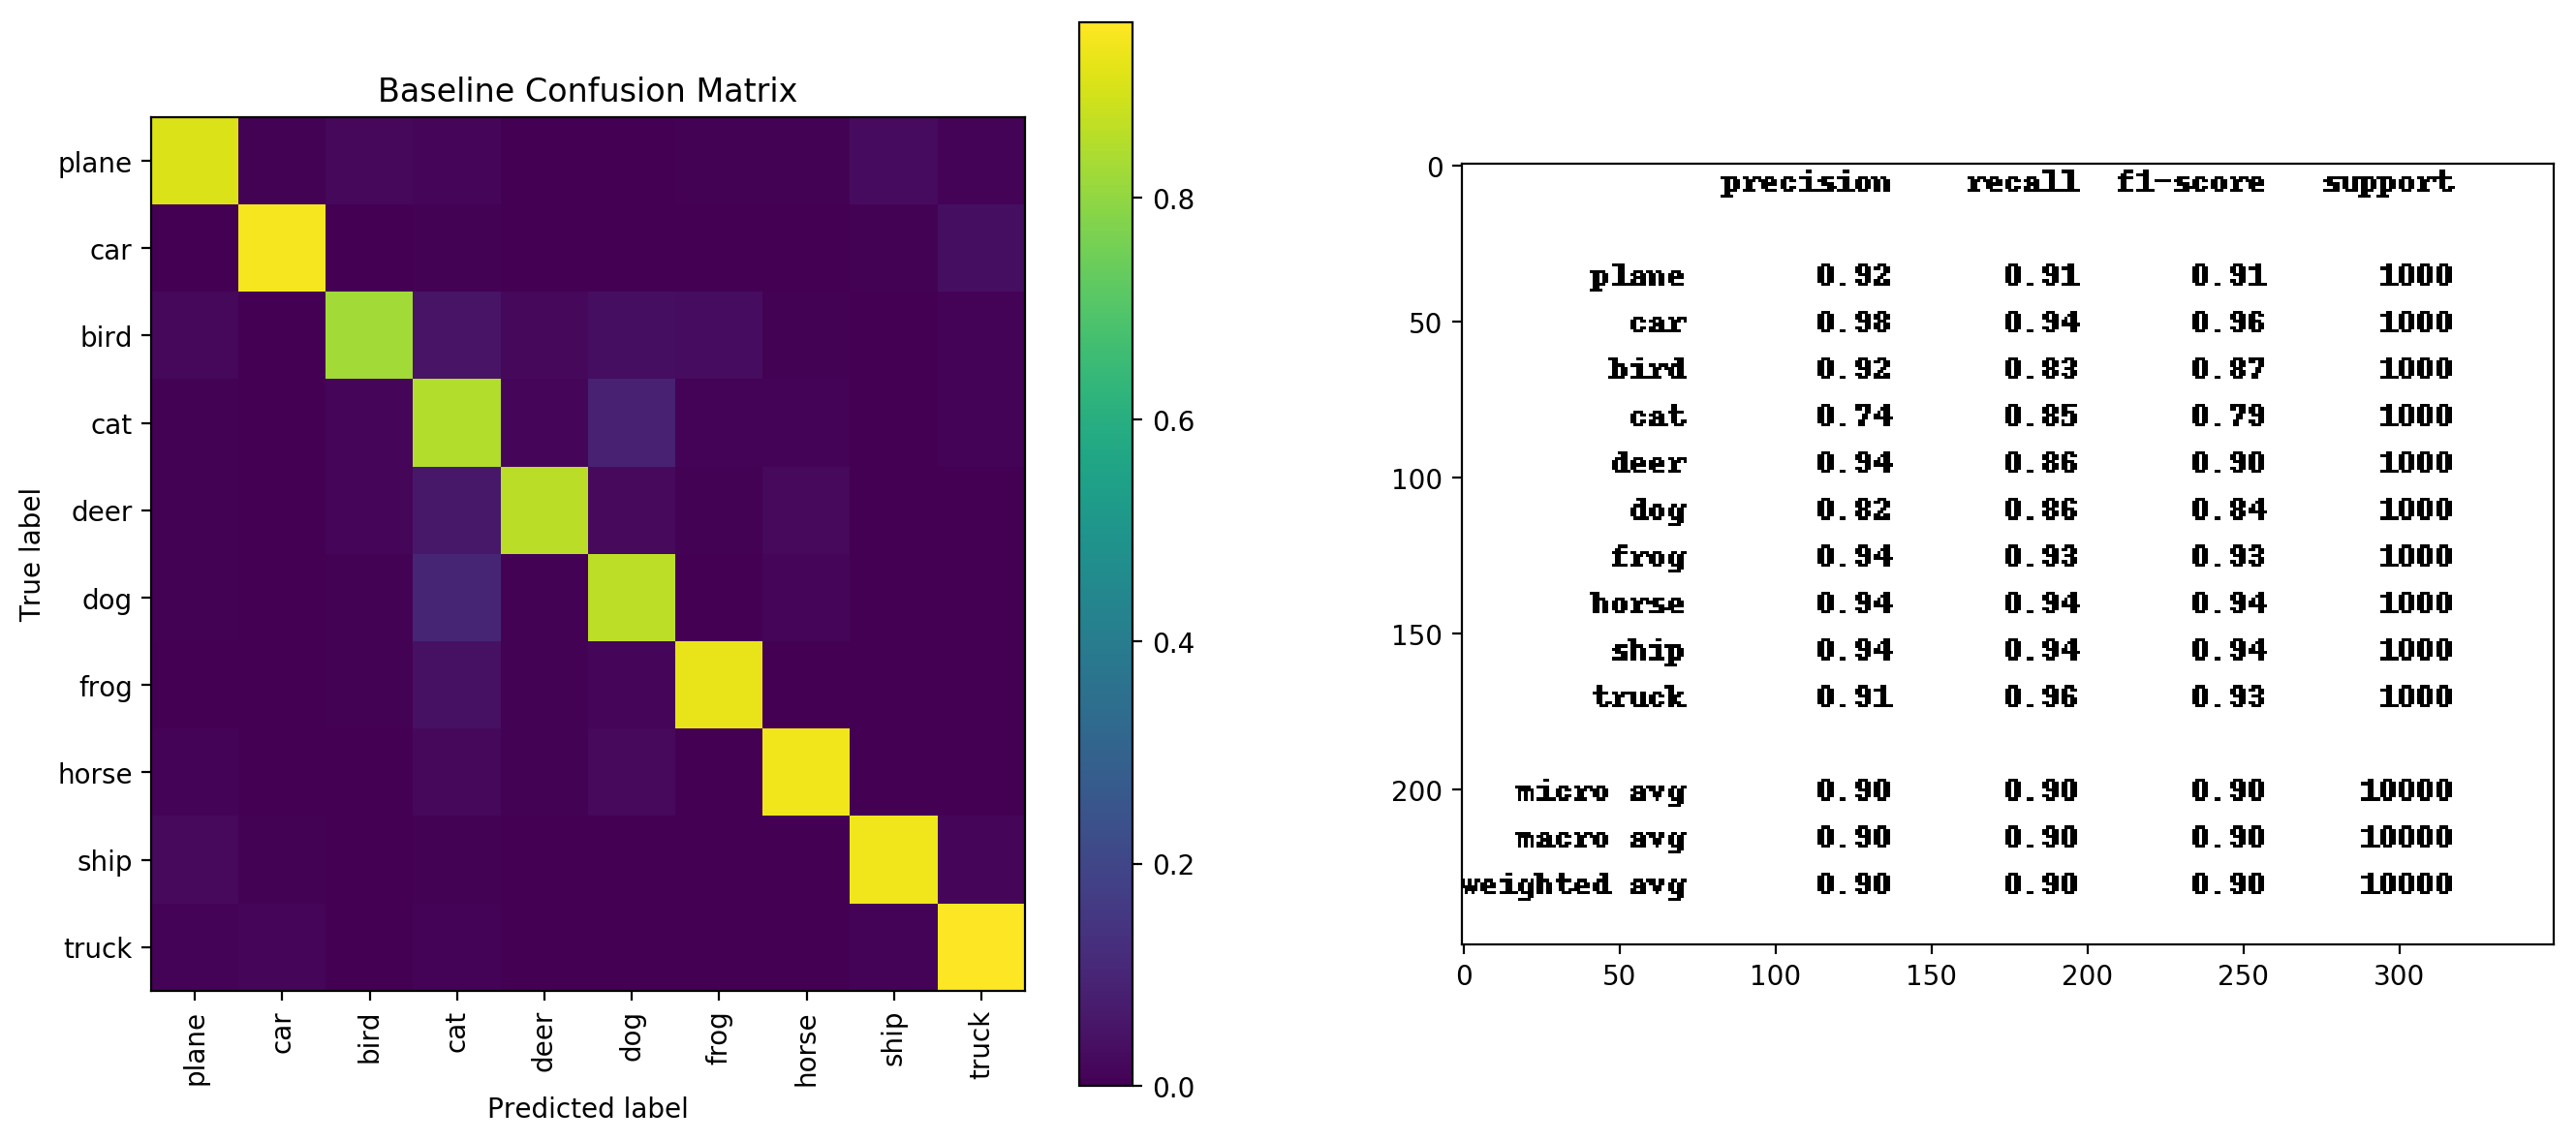

In [8]:
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, "Baseline Confusion Matrix")
# plt.savefig('/HAR_cm.png', format='png')
plt.show()
# print(classification_report(true_labels, model_preds, target_names=labels_name))

# Classification Analysis

In [9]:
table = pd.DataFrame(cm)
table.columns = labels_name
table

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,909,4,20,13,1,2,6,5,29,11
1,2,945,2,7,1,2,0,0,4,37
2,21,1,826,49,19,34,31,7,3,9
3,7,0,15,846,15,88,10,8,3,8
4,6,1,14,60,858,25,6,24,3,3
5,5,0,5,99,6,864,2,14,2,3
6,3,0,6,42,4,14,926,3,1,1
7,8,1,1,20,5,24,1,936,2,2
8,24,4,3,7,1,1,1,2,939,18
9,8,13,1,8,0,0,1,0,11,958


# Mask1

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.4394


/home/ouyangzhihao/anaconda3/envs/OYZH/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


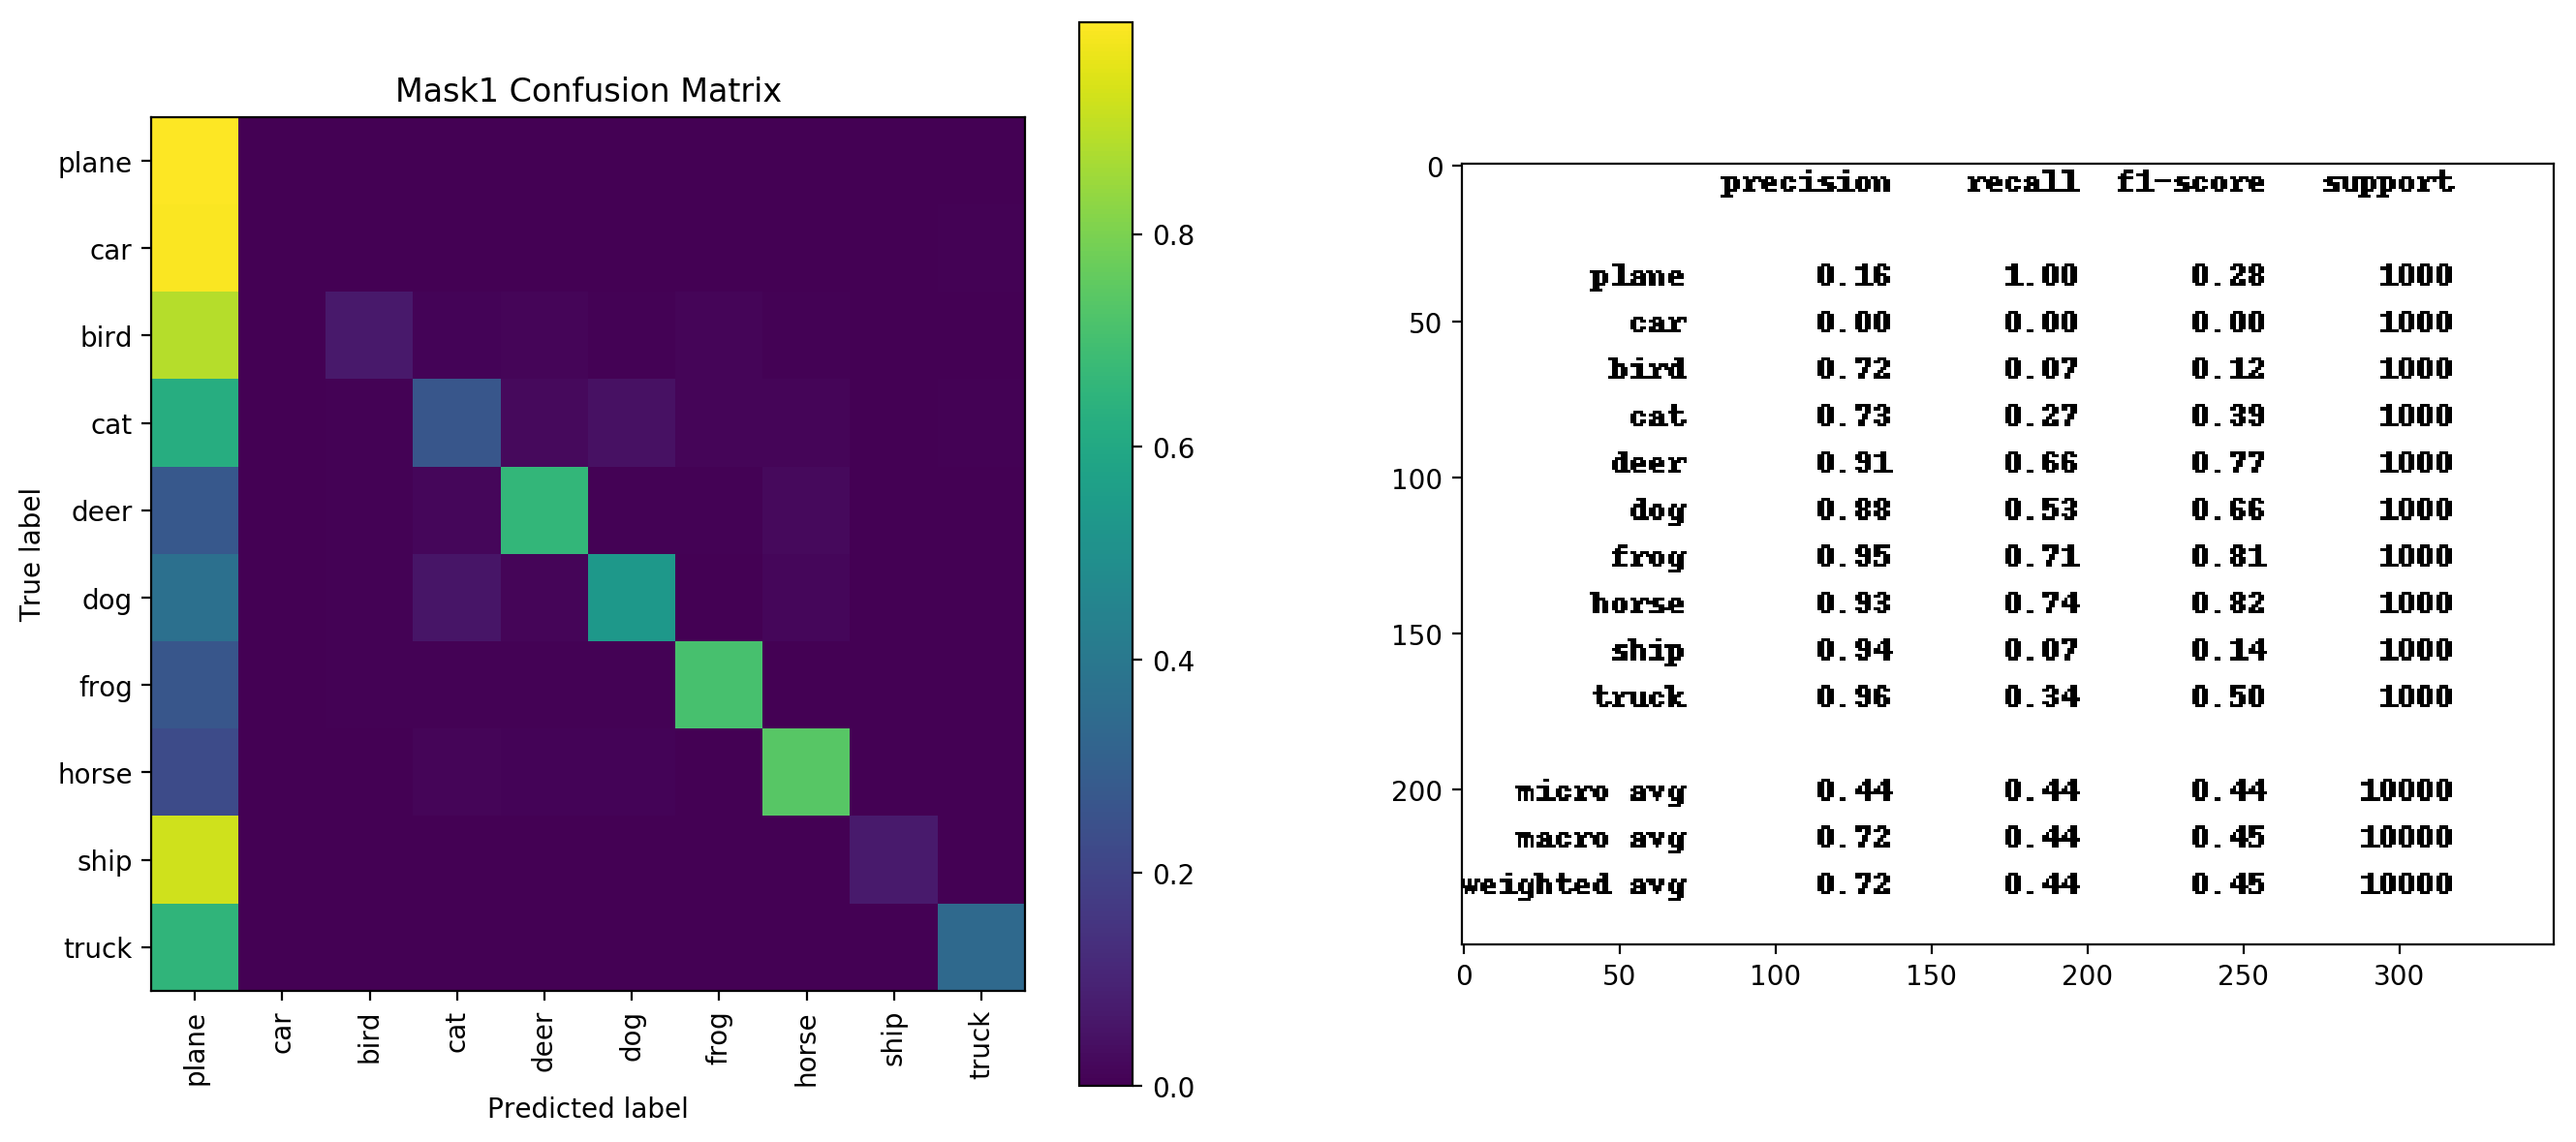

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,999,0,0,1,0,0,0,0,0,0
1,994,0,0,0,0,0,0,0,0,6
2,887,0,67,8,13,7,14,4,0,0
3,624,0,6,268,24,46,12,12,1,7
4,275,0,7,16,661,7,6,27,0,1
5,369,0,7,58,14,532,3,16,1,0
6,269,0,5,4,6,5,709,1,0,1
7,229,0,1,12,8,8,0,741,1,0
8,925,0,0,0,0,0,0,0,74,1
9,655,0,0,0,0,0,0,0,2,343


In [10]:
PATH = '/data/ouyangzhihao/Exp/ICNN/Resnet_ICNN/tb_dir/cifar_exp/test_256bs_150epoch_layer3_Vgg_mask1'
model_path = os.path.join(PATH, 'saved_model.pt')
model.load_state_dict(torch.load(model_path))
use_gpu = True
epoch = 1
phase = 'val'
running_corrects = 0.0
data_len = len(dataloaders[phase])
# print(data_len)
true_labels = []
model_preds = []
for idx,data in enumerate(dataloaders[phase]):
    printF(idx, data_len)
    inputs,labels = data
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    #forward
    outputs = model(inputs, labels, epoch)
    _, preds = torch.max(outputs.data, 1)
    # _,top5_preds = torch.topk(outputs.data,k=5,dim=1)
    # print ('group loss:',group_loss[0])
    y = labels.data
    batch_size = labels.data.shape[0]
    # print(y.resize_(batch_size,1))
    running_corrects += torch.sum(preds == y)
    # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
    epoch_acc = float(running_corrects) /dataset_sizes[phase]
    true_labels.extend(y.cpu().numpy())
    model_preds.extend(preds.cpu().numpy())
print('%s top1 Acc:%.4f'%(phase,epoch_acc))
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, "Mask1 Confusion Matrix")
plt.show() 
# print(classification_report(true_labels, model_preds, target_names=labels_name))
table = pd.DataFrame(cm)
table.columns = labels_name
table

# Mask 1vs0

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.3623


/home/ouyangzhihao/anaconda3/envs/OYZH/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


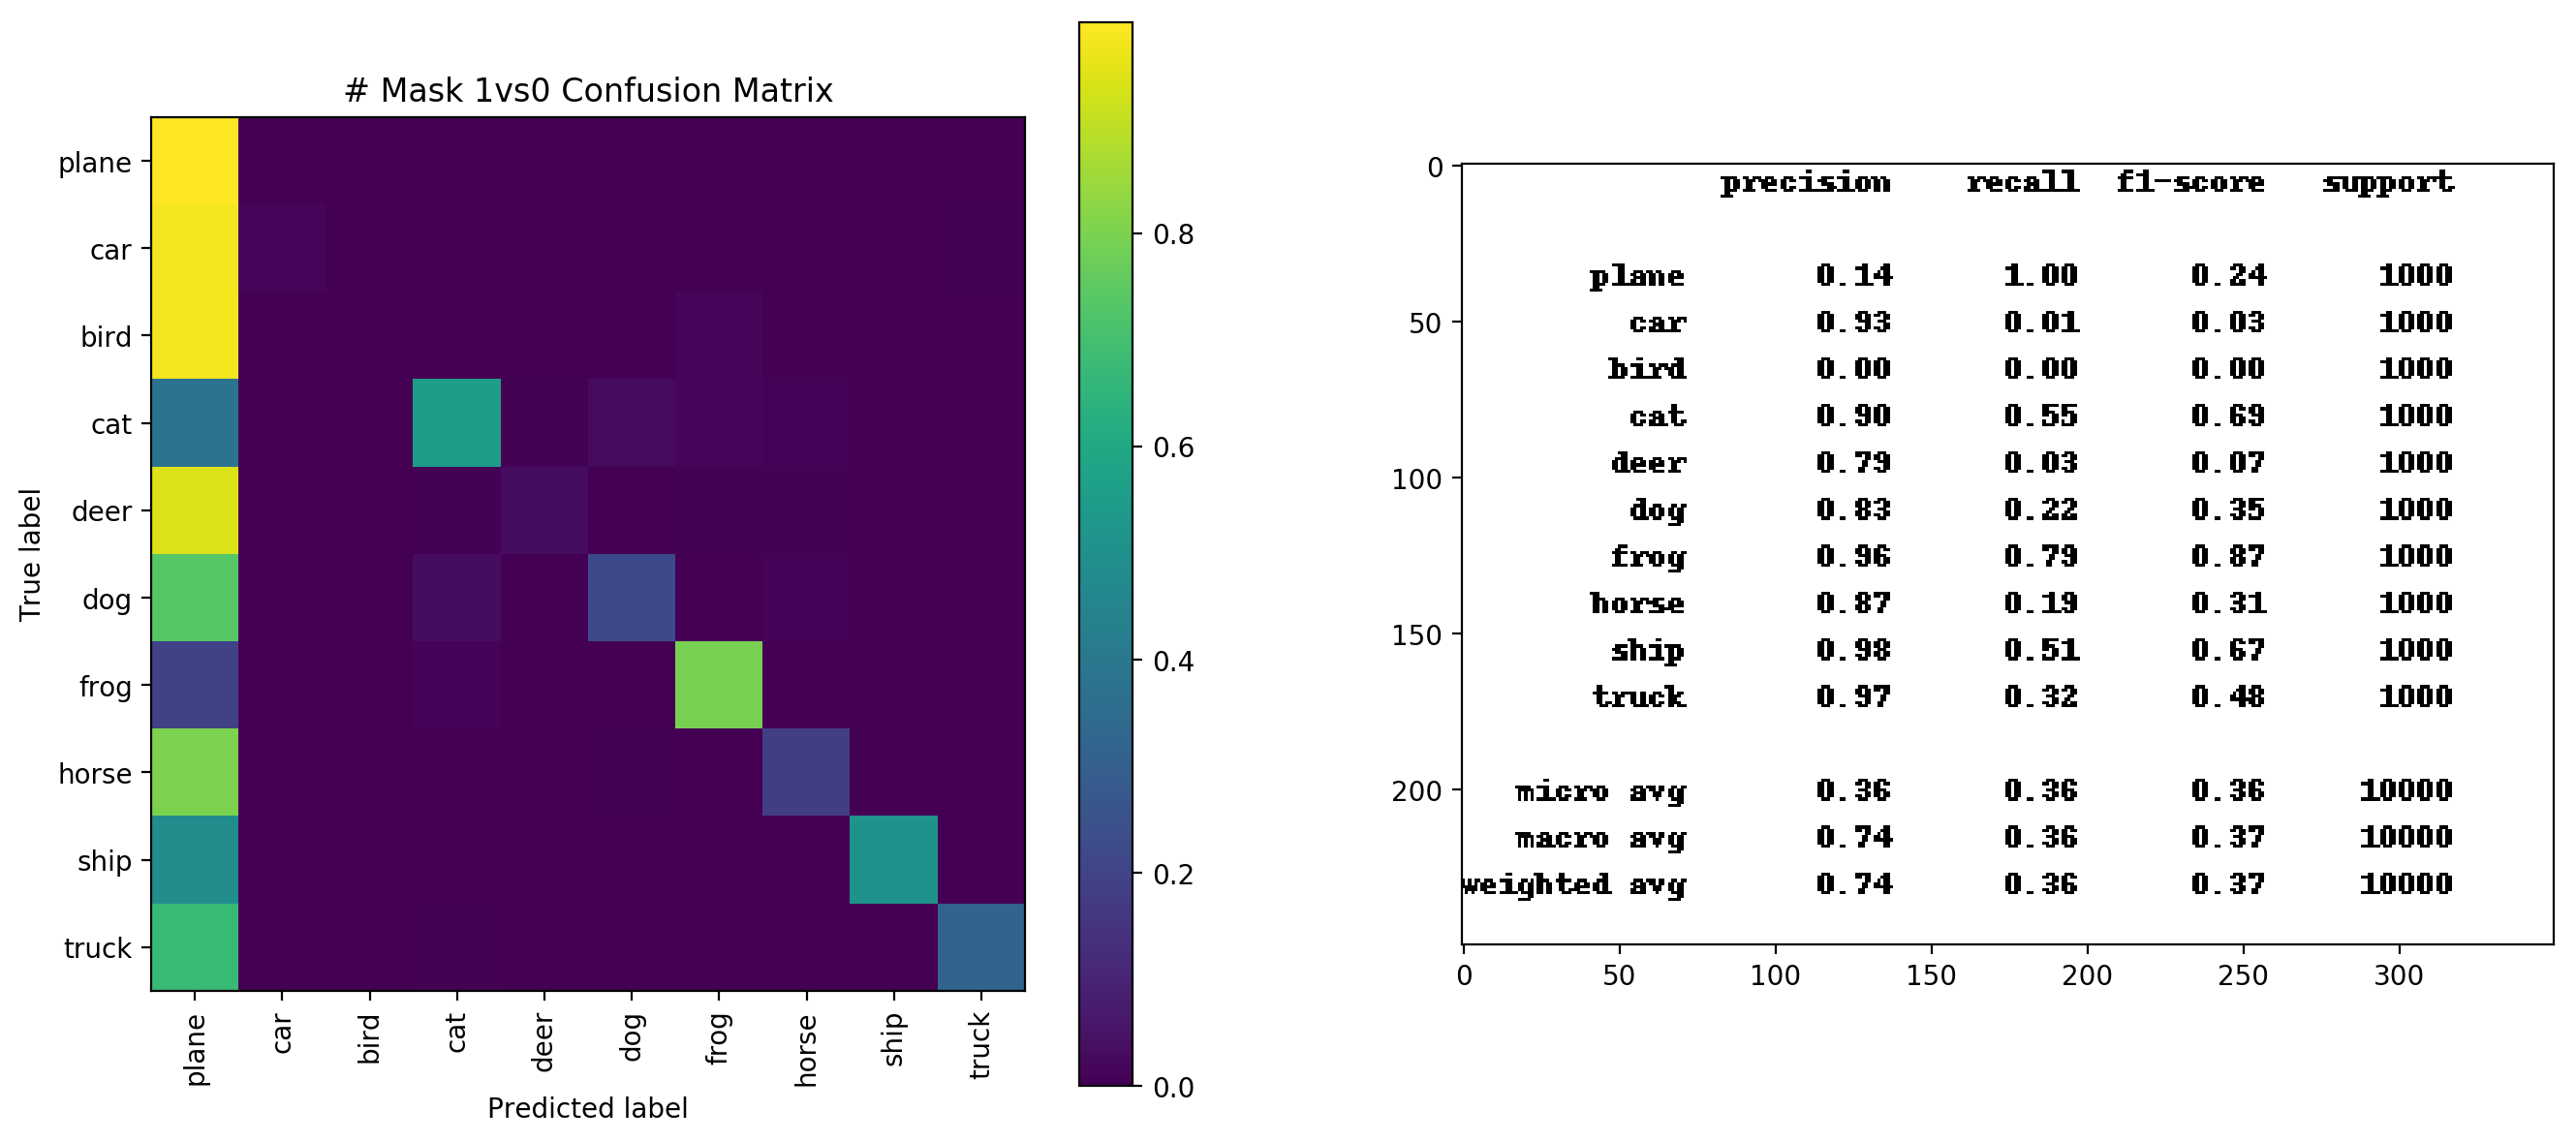

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,998,0,0,1,0,0,0,0,1,0
1,980,14,0,1,0,0,0,0,0,5
2,980,0,0,1,0,3,12,1,3,0
3,381,0,0,554,4,31,16,9,3,2
4,945,0,0,6,34,2,4,7,1,1
5,733,0,0,34,3,219,2,9,0,0
6,195,0,0,8,0,3,793,0,0,1
7,803,0,0,3,2,5,1,186,0,0
8,489,0,0,3,0,0,0,0,508,0
9,676,1,0,5,0,0,0,1,0,317


In [11]:
PATH = '/data/ouyangzhihao/Exp/ICNN/Resnet_ICNN/tb_dir/cifar_exp/test_256bs_150epoch_layer3_Vgg_mask1vs0'
model_path = os.path.join(PATH, 'saved_model.pt')
model.load_state_dict(torch.load(model_path))
use_gpu = True
epoch = 1
phase = 'val'
running_corrects = 0.0
data_len = len(dataloaders[phase])
# print(data_len)
true_labels = []
model_preds = []
for idx,data in enumerate(dataloaders[phase]):
    printF(idx, data_len)
    inputs,labels = data
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    #forward
    outputs = model(inputs, labels, epoch)
    _, preds = torch.max(outputs.data, 1)
    # _,top5_preds = torch.topk(outputs.data,k=5,dim=1)
    # print ('group loss:',group_loss[0])
    y = labels.data
    batch_size = labels.data.shape[0]
    # print(y.resize_(batch_size,1))
    running_corrects += torch.sum(preds == y)
    # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
    epoch_acc = float(running_corrects) /dataset_sizes[phase]
    true_labels.extend(y.cpu().numpy())
    model_preds.extend(preds.cpu().numpy())
print('%s top1 Acc:%.4f'%(phase,epoch_acc))
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, "# Mask 1vs0 Confusion Matrix")
plt.show() 
# print(classification_report(true_labels, model_preds, target_names=labels_name))
table = pd.DataFrame(cm)
table.columns = labels_name
table

# icnn loss 0.3

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.5562


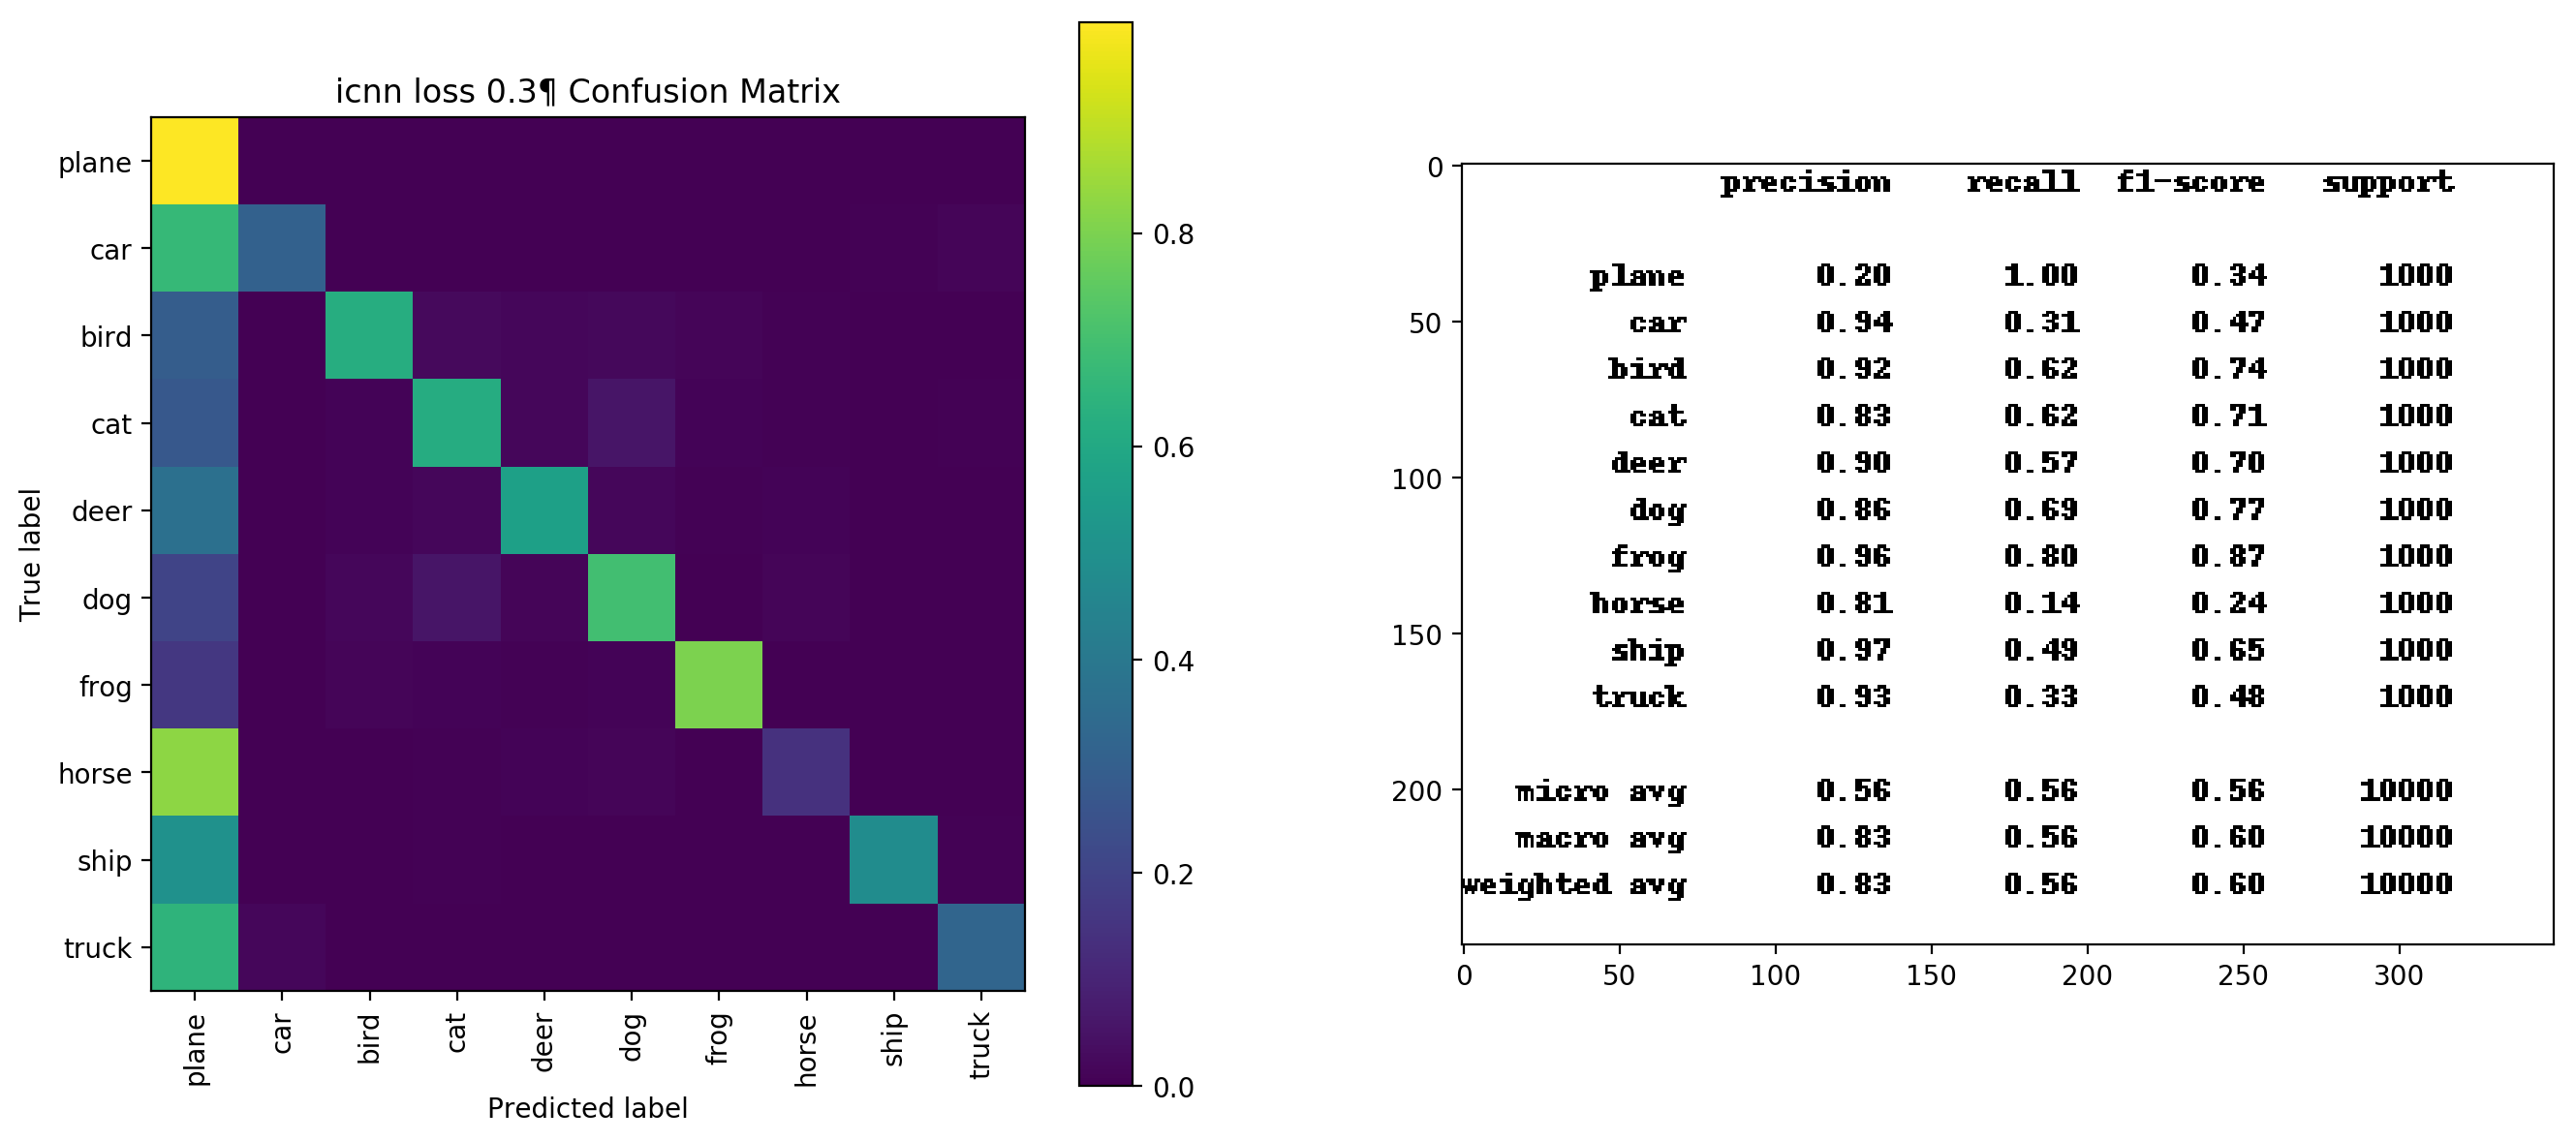

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,998,0,0,0,0,0,0,1,1,0
1,669,309,2,2,0,0,0,0,6,12
2,293,1,620,26,19,21,12,5,2,1
3,274,0,10,616,18,58,11,6,2,5
4,369,1,10,18,569,16,6,10,0,1
5,203,0,17,58,13,694,1,12,1,1
6,162,0,13,11,5,8,800,0,0,1
7,829,0,2,4,9,12,1,143,0,0
8,503,1,1,4,0,0,0,0,486,5
9,650,17,1,3,0,0,1,0,1,327


In [12]:
PATH = '/data/ouyangzhihao/Exp/ICNN/Resnet_ICNN/tb_dir/cifar_exp/test_256bs_150epoch_layer3_Vgg_mask1_iloss0.3'
model_path = os.path.join(PATH, 'saved_model.pt')
model.load_state_dict(torch.load(model_path))
use_gpu = True
epoch = 1
phase = 'val'
running_corrects = 0.0
data_len = len(dataloaders[phase])
# print(data_len)
true_labels = []
model_preds = []
for idx,data in enumerate(dataloaders[phase]):
    printF(idx, data_len)
    inputs,labels = data
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    #forward
    outputs = model(inputs, labels, epoch)
    _, preds = torch.max(outputs.data, 1)
    # _,top5_preds = torch.topk(outputs.data,k=5,dim=1)
    # print ('group loss:',group_loss[0])
    y = labels.data
    batch_size = labels.data.shape[0]
    # print(y.resize_(batch_size,1))
    running_corrects += torch.sum(preds == y)
    # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
    epoch_acc = float(running_corrects) /dataset_sizes[phase]
    true_labels.extend(y.cpu().numpy())
    model_preds.extend(preds.cpu().numpy())
print('%s top1 Acc:%.4f'%(phase,epoch_acc))
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, "icnn loss 0.3¶ Confusion Matrix")
plt.show() 
# print(classification_report(true_labels, model_preds, target_names=labels_name))
table = pd.DataFrame(cm)
table.columns = labels_name
table